# **Sentiment Analysis of #BlackLivesMatter Tweets**

## **Introduction**
Social media platforms like Twitter have become crucial in shaping public opinion and movements. The #BlackLivesMatter movement has gained significant attention, with millions of tweets discussing racial justice, protests, and activism. Understanding public sentiment regarding this movement can provide insights into societal perspectives, highlight key concerns, and help organizations respond effectively.

This project performs sentiment analysis on a dataset of tweets containing the hashtag **#BlackLivesMatter**. The dataset was obtained through **web scraping using Selenium**, allowing us to collect real-time tweets for analysis. The analysis involves:
- **Data Cleaning**: Removing unnecessary elements such as URLs, mentions, and special characters.
- **Exploratory Data Analysis (EDA)**: Visualizing tweet sentiments, hashtag distributions, and user engagement metrics.
- **Sentiment Classification**: Using both traditional and deep-learning models to classify tweets as **Positive, Negative, or Neutral**.
- **Trend Analysis**: Investigating how sentiments evolved over time and their correlation with engagement metrics such as likes, retweets, and replies.

---

### **Models Used for Sentiment Analysis**
To classify the sentiment of tweets, we will implement three key models:

#### **a) Logistic Regression**
- A traditional machine learning model using **TF-IDF (Term Frequency-Inverse Document Frequency)** to convert text into numerical representations.
- Trained using **sklearn's LogisticRegression** module.
- Evaluated using **accuracy, precision, recall, and F1-score**.

#### **b) XGBoost (Extreme Gradient Boosting)**
- A powerful ensemble learning technique that improves classification performance by training multiple decision trees.
- Uses **TfidfVectorizer** for text feature extraction.
- Implemented using **XGBoost's `xgb.XGBClassifier`**.

#### **c) BERT (Bidirectional Encoder Representations from Transformers)**
- A deep-learning transformer model that understands context using bidirectional training.
- Uses **pre-trained BERT tokenizer** for text tokenization.
- Fine-tuned using **Hugging Face's `BertForSequenceClassification`** and the **Trainer API**.
- Evaluated using **classification reports and ROC-AUC curves**.

---

Next, we proceed with **data loading and preprocessing**, ensuring that the scraped tweets are properly cleaned and prepared for sentiment analysis.



## **1️⃣ Data Loading and Preprocessing**

In [64]:
# Import required libraries
import pandas as pd
import squarify
import collections
import re
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings("ignore")


import torch
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
from sklearn.preprocessing import label_binarize, LabelEncoder
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments


### **Loading the Dataset**
We'll start by loading the dataset containing tweets with the hashtag **#BlackLivesMatter**.

In [65]:
df = pd.read_csv("tweets_live9.csv")
df.head()

,UserTags,TimeStamps,Tweets,Replies,Retweets,Likes
0,Angela Gardner\n@AngieG4ability\n·\n12h,2024-06-29T19:44:38.000Z,Investing in our children is the best thing. A...,1,3,16
1,Black Lives Matter\n@Blklivesmatter\n·\n12h,2024-06-29T19:29:52.000Z,Black Boy JOY Alert!\n\nWe’re proud to support...,3,29,195
2,"Gabrielle A. Perry, MPH\n@GeauxGabrielle\n·\nJ...",2024-06-28T14:52:07.000Z,The homeless will be rounded up by police and ...,1.9K,30K,91K
3,"Bryan H., Esq.\n@X_BryanH\n·\nJun 28",2024-06-28T14:55:27.000Z,The Supreme Court has:\n\n-Overturned Roe v. W...,8.5K,40K,136K
4,Black Lives Matter\n@Blklivesmatter\n·\nJun 27,2024-06-27T02:00:23.000Z,CNN's exclusion of Black-owned media from the ...,8,39,69


## **2️⃣ Data Preprocessing**  
Before performing sentiment analysis, we clean the tweet text by:  
✔ Removing mentions, hashtags, and links  
✔ Converting text to lowercase  
✔ Removing special characters and numbers  

In [5]:
df['TimeStamps'] = pd.to_datetime(df['TimeStamps'])

def clean_tweet(tweet):
    if isinstance(tweet, str):
        tweet = re.sub(r'http\S+', '', tweet)  # Remove URLs
        tweet = re.sub(r'@\S+', '', tweet)     # Remove mentions
        tweet = re.sub(r'#\S+', '', tweet)     # Remove hashtags
        tweet = re.sub(r'[^A-Za-z0-9\s]', '', tweet)  # Remove special characters
        tweet = tweet.lower()  # Convert to lowercase
    else:
        tweet = ''  # If the tweet is not a string, convert to an empty string
    return tweet

df['Cleaned_Tweets'] = df['Tweets'].apply(clean_tweet)

# Process the numeric columns
def process_k_values(value):
    value = str(value)
    if 'K' in value:
        return float(value.replace('K', '')) * 1000
    return float(value)

df['Replies'] = df['Replies'].apply(process_k_values)
df['Retweets'] = df['Retweets'].apply(process_k_values)
df['Likes'] = df['Likes'].apply(process_k_values)


In [6]:
df

,UserTags,TimeStamps,Tweets,Replies,Retweets,Likes,Cleaned_Tweets
0,Angela Gardner\n@AngieG4ability\n·\n12h,2024-06-29 19:44:38+00:00,Investing in our children is the best thing. A...,1.0,3.0,16.0,investing in our children is the best thing an...
1,Black Lives Matter\n@Blklivesmatter\n·\n12h,2024-06-29 19:29:52+00:00,Black Boy JOY Alert!\n\nWe’re proud to support...,3.0,29.0,195.0,black boy joy alert\n\nwere proud to support t...
2,"Gabrielle A. Perry, MPH\n@GeauxGabrielle\n·\nJ...",2024-06-28 14:52:07+00:00,The homeless will be rounded up by police and ...,1900.0,30000.0,91000.0,the homeless will be rounded up by police and ...
3,"Bryan H., Esq.\n@X_BryanH\n·\nJun 28",2024-06-28 14:55:27+00:00,The Supreme Court has:\n\n-Overturned Roe v. W...,8500.0,40000.0,136000.0,the supreme court has\n\noverturned roe v wade...
4,Black Lives Matter\n@Blklivesmatter\n·\nJun 27,2024-06-27 02:00:23+00:00,CNN's exclusion of Black-owned media from the ...,8.0,39.0,69.0,cnns exclusion of blackowned media from the pr...
...,...,...,...,...,...,...,...
459,"Legal Defense Fund\n@NAACP_LDF\n·\nJan 27, 2023",2023-01-27 19:01:01+00:00,Tyre Nichols loved to take photos of sunsets. ...,2.0,136.0,367.0,tyre nichols loved to take photos of sunsets h...
460,"COLONIALISM IS FALLING, PALESTINE WILL BE FREE...",2023-01-27 15:16:05+00:00,Diversifying the police force doesn’t end raci...,1000.0,9500.0,38000.0,diversifying the police force doesnt end racis...
461,"Haymarket Books\n@haymarketbooks\n·\nJan 27, 2023",2023-01-27 18:37:17+00:00,It’s still defund and abolish the police,11.0,698.0,2600.0,its still defund and abolish the police
462,"Haymarket Books\n@haymarketbooks\n·\nJan 24, 2023",2023-01-24 19:50:08+00:00,"If you are a high school student in Florida, w...",20.0,1800.0,3500.0,if you are a high school student in florida we...


## **3️⃣ Sentiment Analysis**  
To determine the sentiment of each tweet, we use **TextBlob**, a natural language processing (NLP) library that computes the **polarity score** of text.  

✔ **Positive Sentiment** → Polarity score > 0  
✔ **Neutral Sentiment** → Polarity score = 0  
✔ **Negative Sentiment** → Polarity score < 0  

The following function calculates sentiment polarity for each tweet:  

In [7]:
def get_sentiment(tweet):
    analysis = TextBlob(tweet)
    return analysis.sentiment.polarity

df['Sentiment'] = df['Cleaned_Tweets'].apply(get_sentiment)


In [8]:
df

,UserTags,TimeStamps,Tweets,Replies,Retweets,Likes,Cleaned_Tweets,Sentiment
0,Angela Gardner\n@AngieG4ability\n·\n12h,2024-06-29 19:44:38+00:00,Investing in our children is the best thing. A...,1.0,3.0,16.0,investing in our children is the best thing an...,1.000000
1,Black Lives Matter\n@Blklivesmatter\n·\n12h,2024-06-29 19:29:52+00:00,Black Boy JOY Alert!\n\nWe’re proud to support...,3.0,29.0,195.0,black boy joy alert\n\nwere proud to support t...,0.522222
2,"Gabrielle A. Perry, MPH\n@GeauxGabrielle\n·\nJ...",2024-06-28 14:52:07+00:00,The homeless will be rounded up by police and ...,1900.0,30000.0,91000.0,the homeless will be rounded up by police and ...,0.000000
3,"Bryan H., Esq.\n@X_BryanH\n·\nJun 28",2024-06-28 14:55:27+00:00,The Supreme Court has:\n\n-Overturned Roe v. W...,8500.0,40000.0,136000.0,the supreme court has\n\noverturned roe v wade...,0.350000
4,Black Lives Matter\n@Blklivesmatter\n·\nJun 27,2024-06-27 02:00:23+00:00,CNN's exclusion of Black-owned media from the ...,8.0,39.0,69.0,cnns exclusion of blackowned media from the pr...,0.100000
...,...,...,...,...,...,...,...,...
459,"Legal Defense Fund\n@NAACP_LDF\n·\nJan 27, 2023",2023-01-27 19:01:01+00:00,Tyre Nichols loved to take photos of sunsets. ...,2.0,136.0,367.0,tyre nichols loved to take photos of sunsets h...,0.325000
460,"COLONIALISM IS FALLING, PALESTINE WILL BE FREE...",2023-01-27 15:16:05+00:00,Diversifying the police force doesn’t end raci...,1000.0,9500.0,38000.0,diversifying the police force doesnt end racis...,0.000000
461,"Haymarket Books\n@haymarketbooks\n·\nJan 27, 2023",2023-01-27 18:37:17+00:00,It’s still defund and abolish the police,11.0,698.0,2600.0,its still defund and abolish the police,0.000000
462,"Haymarket Books\n@haymarketbooks\n·\nJan 24, 2023",2023-01-24 19:50:08+00:00,"If you are a high school student in Florida, w...",20.0,1800.0,3500.0,if you are a high school student in florida we...,0.223333


## **4️⃣ Exploratory Data Analysis (EDA)** 
### Summary Statistics
To understand the dataset, we generate summary statistics using **`df.describe()`**. This provides insights into:  

✔ **Count** → Number of non-null values in each column  
✔ **Mean** → Average values for numerical columns  
✔ **Standard Deviation (std)** → Measures data variability  
✔ **Minimum & Maximum Values** → Identifies data range  
✔ **Percentiles (25%, 50%, 75%)** → Helps understand data distribution  

The following command outputs descriptive statistics:  

In [10]:
df.describe()

,Replies,Retweets,Likes,Sentiment
count,456.000000,458.000000,464.00000,464.000000
mean,175.173246,840.903930,3271.62069,0.080388
std,1838.239872,3633.603078,13722.75720,0.236685
min,1.000000,1.000000,1.00000,-0.800000
25%,6.000000,9.000000,33.75000,-0.036865
50%,15.000000,25.000000,85.50000,0.027778
75%,35.000000,124.000000,416.75000,0.200000
max,38000.000000,43000.000000,139000.00000,1.000000


### **4.1 Word Cloud of #BlackLivesMatter Tweets**  
To visualize the most frequently occurring words in the dataset, we generate a **word cloud** using the `WordCloud` library. This highlights the most common terms in tweets. 

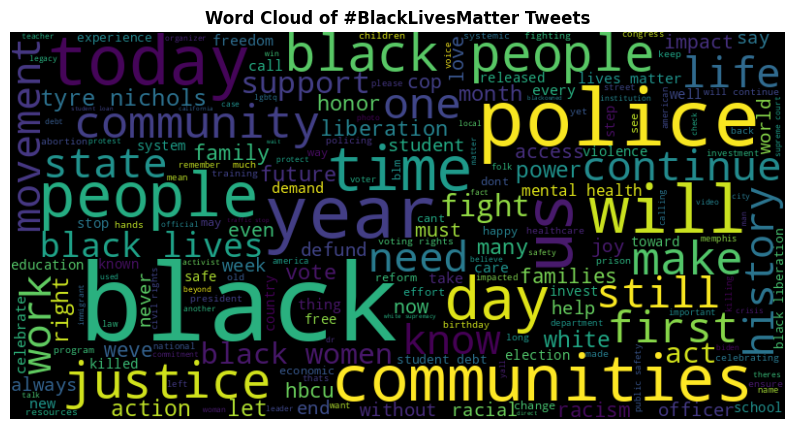

In [26]:
# Combine all cleaned tweets into one large string
all_words = ' '.join([tweet for tweet in df['Cleaned_Tweets']])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(all_words)

# Plot the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud of #BlackLivesMatter Tweets',  fontweight='bold')
plt.show()


### **4.2 Sentiment Distribution - Treemap Visualization**
We classify tweets as Positive, Negative, or Neutral based on sentiment scores and visualize the distribution using a treemap.

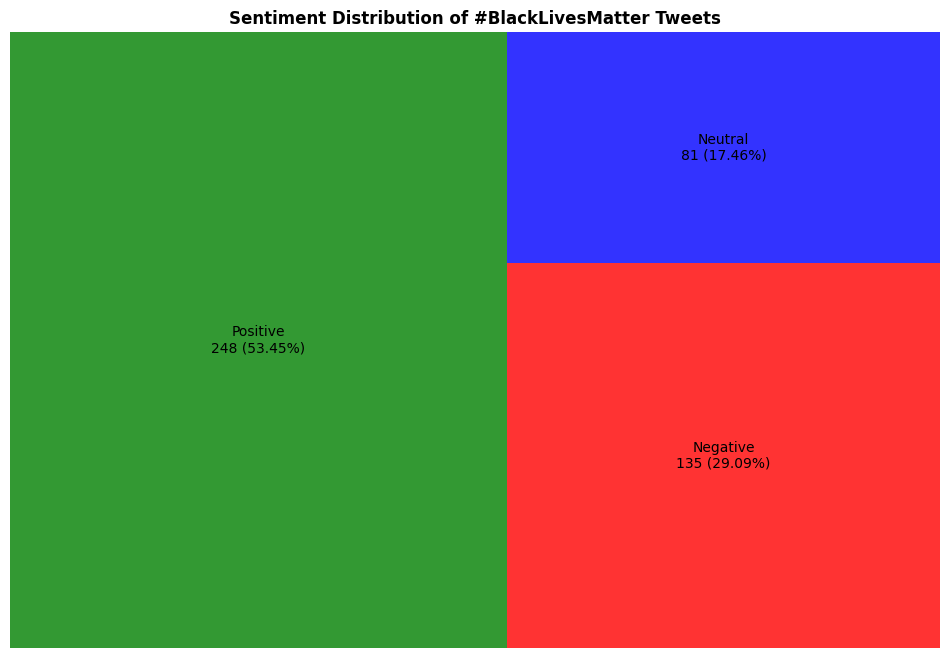

In [25]:
# Create sentiment labels
df['Sentiment_Label'] = df['Sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
# Prepare data for the treemap
sentiment_counts = df['Sentiment_Label'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']
# Calculate percentages
total_count = sentiment_counts['Count'].sum()
sentiment_counts['Percentage'] = (sentiment_counts['Count'] / total_count) * 100
sentiment_counts['Label'] = sentiment_counts.apply(lambda x: f"{x['Sentiment']}\n{x['Count']} ({x['Percentage']:.2f}%)", axis=1)

# Plot the treemap with percentages
plt.figure(figsize=(12, 8))
colors = ['green', 'red', 'blue']
squarify.plot(sizes=sentiment_counts['Count'], label=sentiment_counts['Label'], color=colors, alpha=.8)
plt.title('Sentiment Distribution of #BlackLivesMatter Tweets', fontweight='bold')
plt.axis('off')
plt.show()

### **4.3 Word Cloud of Sentiment-Based Words**
We analyze the most frequent Positive, Negative, and Neutral words using VADER Sentiment Analysis and generate word clouds for each category.

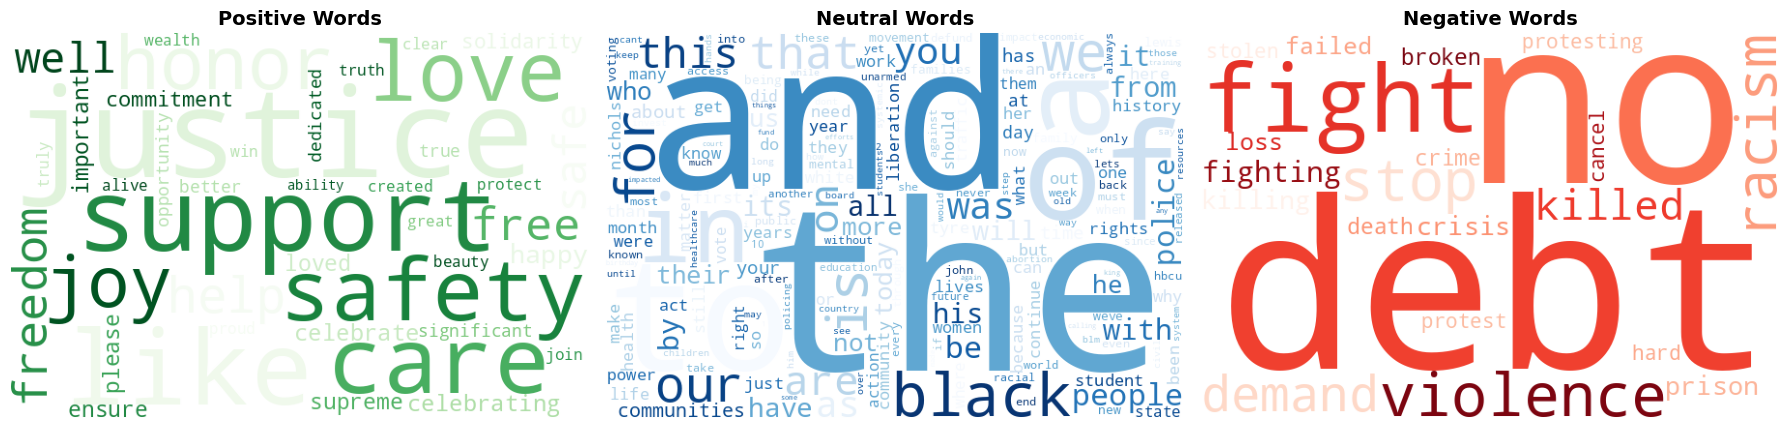

In [23]:
# Initialize VADER Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Function to classify words correctly into positive, neutral, or negative
def classify_word_sentiment(word):
    score = sia.polarity_scores(word)['compound']
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

# Function to extract and classify common words
def get_most_common_words(text_series, num_words=464):
    all_words = ' '.join(text_series).split()
    common_words = Counter(all_words).most_common(num_words)
    
    # Classify words correctly based on sentiment scores
    sentiment_words = {'Positive': {}, 'Neutral': {}, 'Negative': {}}
    for word, count in common_words:
        category = classify_word_sentiment(word)
        sentiment_words[category][word] = count  # Store words in respective categories
    
    return sentiment_words

# Get properly categorized words
sentiment_words = get_most_common_words(df['Cleaned_Tweets'])

# Define color schemes
color_schemes = {
    "Positive": "Greens",
    "Neutral": "Blues",
    "Negative": "Reds"
}

# Create word clouds for each sentiment
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, sentiment in zip(axes, ['Positive', 'Neutral', 'Negative']):
    wordcloud = WordCloud(
        width=600, height=400, colormap=color_schemes[sentiment], background_color='white'
    ).generate_from_frequencies(sentiment_words[sentiment])
    
    ax.imshow(wordcloud)
    ax.set_title(f"{sentiment} Words", fontsize=14, fontweight='bold')
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

### **4.4 Top 10 Hashtags Used in Tweets**
This analysis identifies the most commonly used hashtags in #BlackLivesMatter tweets.

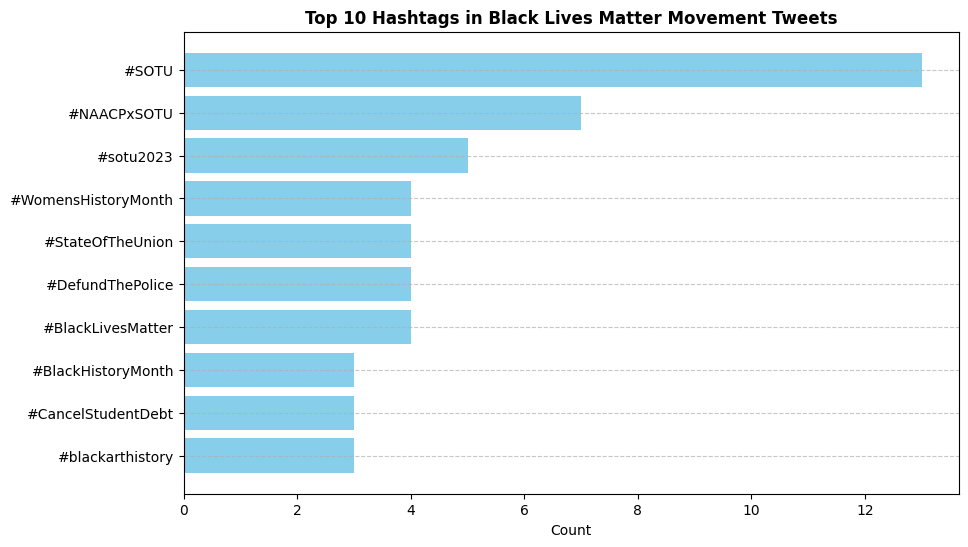

In [46]:
# Ensure all tweets are strings and handle non-string entries
df['Tweets'] = df['Tweets'].astype(str)

# Extract hashtags from the original tweets
df['Hashtags'] = df['Tweets'].apply(lambda x: re.findall(r'#\w+', x))

# Flatten the list of hashtags and count frequencies
all_hashtags = [hashtag for sublist in df['Hashtags'] for hashtag in sublist]
hashtag_counts = collections.Counter(all_hashtags)

# Convert to DataFrame for easier handling
hashtag_df = pd.DataFrame(hashtag_counts.most_common(10), columns=['Hashtag', 'Count'])

# Plot the most common hashtags
plt.figure(figsize=(10, 6))
plt.barh(hashtag_df['Hashtag'], hashtag_df['Count'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 10 Hashtags in Black Lives Matter Movement Tweets', fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### **4.5 Most Mentioned Twitter Handles**
We extract and visualize the top 10 most mentioned Twitter handles in tweets.

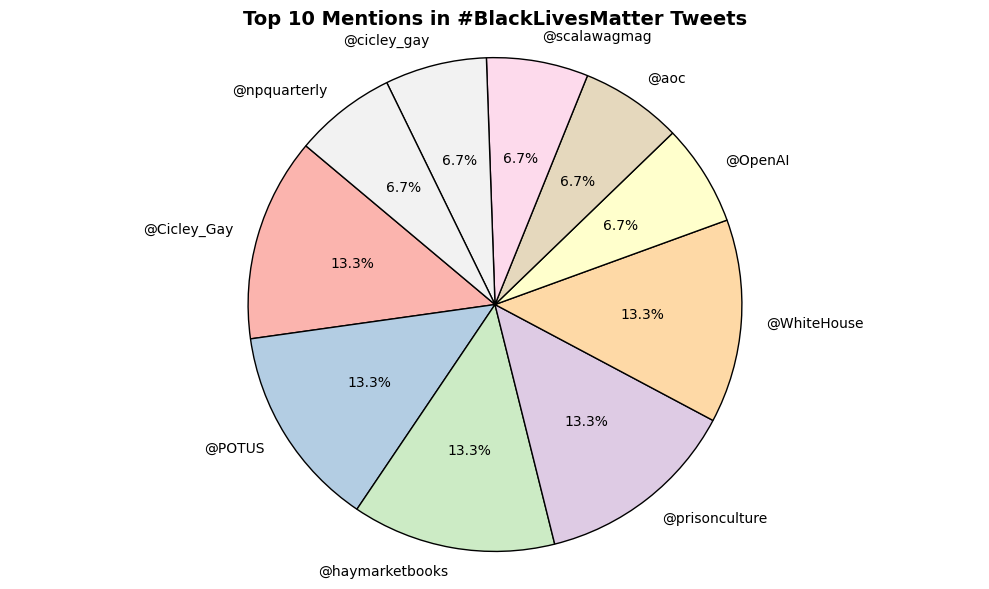

In [29]:
# Extract mentions from tweets
df['Mentions'] = df['Tweets'].astype(str).apply(lambda x: re.findall(r'@\w+', x))

# Flatten the list of mentions and count frequencies
all_mentions = [mention for mentions in df['Mentions'] for mention in mentions]
mention_counts = collections.Counter(all_mentions)

# Convert to DataFrame and select top 10 mentions
mention_df = pd.DataFrame(mention_counts.most_common(10), columns=['Mention', 'Count'])

# Plot the most common mentions as a pie chart
plt.figure(figsize=(10, 6))
colors = plt.cm.Pastel1(range(len(mention_df)))  # Subtle color scheme
plt.pie(mention_df['Count'], labels=mention_df['Mention'], autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'black'})
plt.title('Top 10 Mentions in #BlackLivesMatter Tweets', fontsize=14, fontweight='bold')
plt.axis('equal')  # Ensures the pie is drawn as a circle
plt.tight_layout()

plt.show()

### **4.6 Distribution of Tweet Word Counts**
We analyze the number of words in each tweet using a histogram.

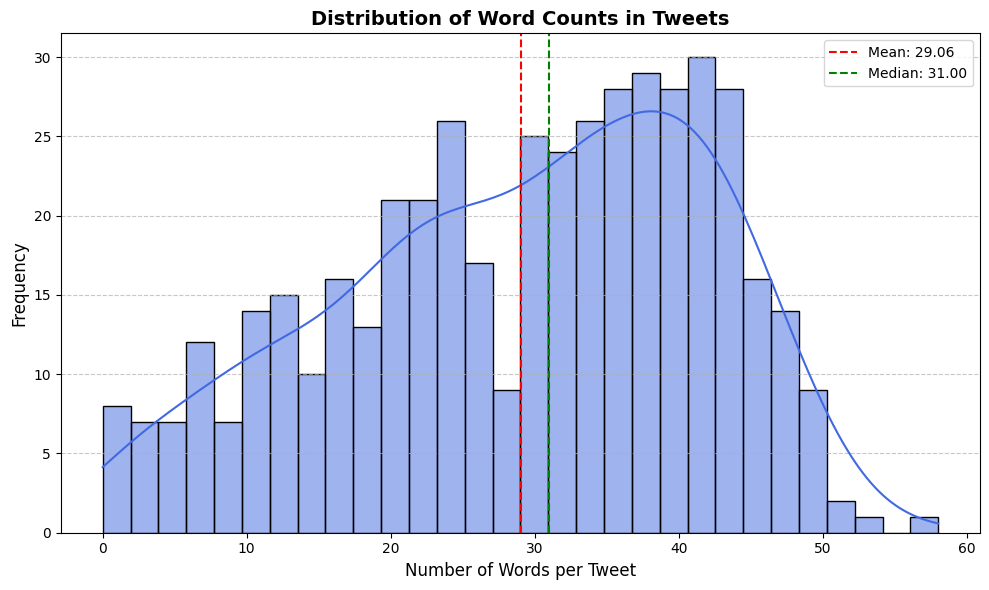

In [33]:
# Ensure 'Cleaned_Tweets' contains strings
df['Cleaned_Tweets'] = df['Cleaned_Tweets'].astype(str)

# Calculate the number of words in each tweet
df['Word_Lengths'] = df['Cleaned_Tweets'].apply(lambda x: len(x.split()))

# Create histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['Word_Lengths'], bins=30, kde=True, color='royalblue', edgecolor='black')

plt.title('Distribution of Word Counts in Tweets', fontsize=14, fontweight='bold')
plt.xlabel('Number of Words per Tweet', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Add mean and median lines
mean_length = df['Word_Lengths'].mean()
median_length = df['Word_Lengths'].median()
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_length:.2f}')
plt.axvline(median_length, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {median_length:.2f}')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

### **4.7 Word Length Analysis by Sentiment**

This visualization enhances the understanding of word length distributions across different sentiment labels.

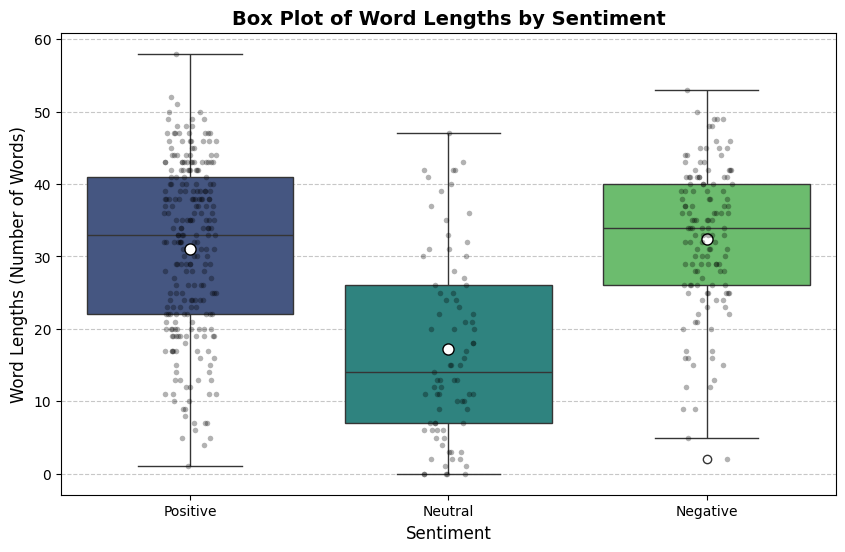

In [37]:
# Create an enhanced box plot for word lengths based on sentiment
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    x='Sentiment_Label', 
    y='Word_Lengths', 
    data=df, 
    palette="viridis",  # Better color scheme
    showmeans=True,      # Display mean values
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": 8}
)

# Add jittered swarmplot for better visibility of data points
sns.stripplot(
    x='Sentiment_Label', 
    y='Word_Lengths', 
    data=df, 
    size=4, 
    color='black', 
    alpha=0.3, 
    jitter=True
)

# Improve title and labels
ax.set_title('Box Plot of Word Lengths by Sentiment', fontsize=14, fontweight='bold')
ax.set_xlabel('Sentiment', fontsize=12)
ax.set_ylabel('Word Lengths (Number of Words)', fontsize=12)

# Improve grid visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

### **4.8 Trend of Tweets Over Time**
We examine the daily frequency of tweets over time.

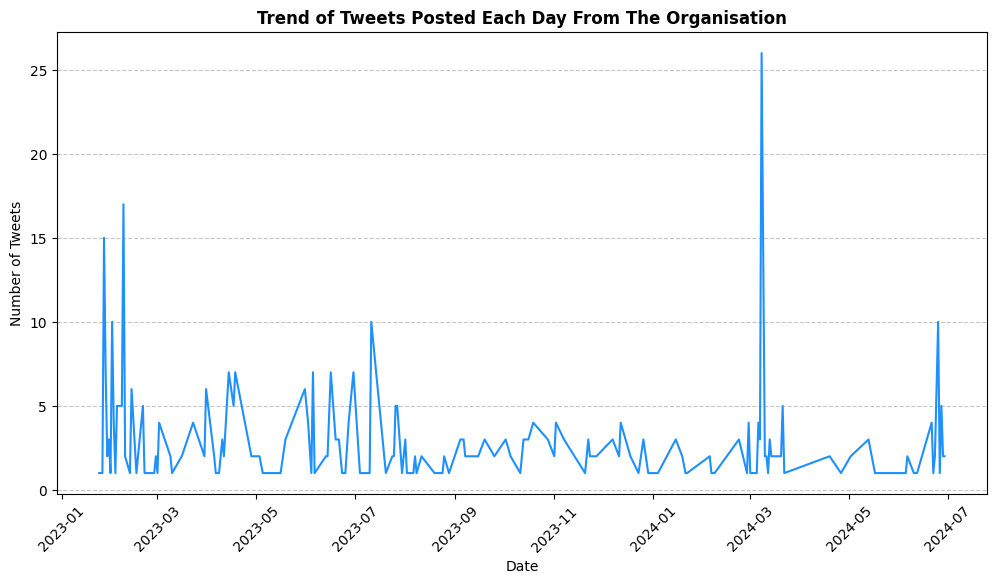

In [42]:

# Extract the date from the TimeStamp
df['Date'] = df['TimeStamps'].dt.date

# Plot the trend of tweets posted each day
daily_tweets = df.groupby('Date').size()
plt.figure(figsize=(12, 6))
daily_tweets.plot(kind='line', color='dodgerblue')
plt.title('Trend of Tweets Posted Each Day From The Organisation', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


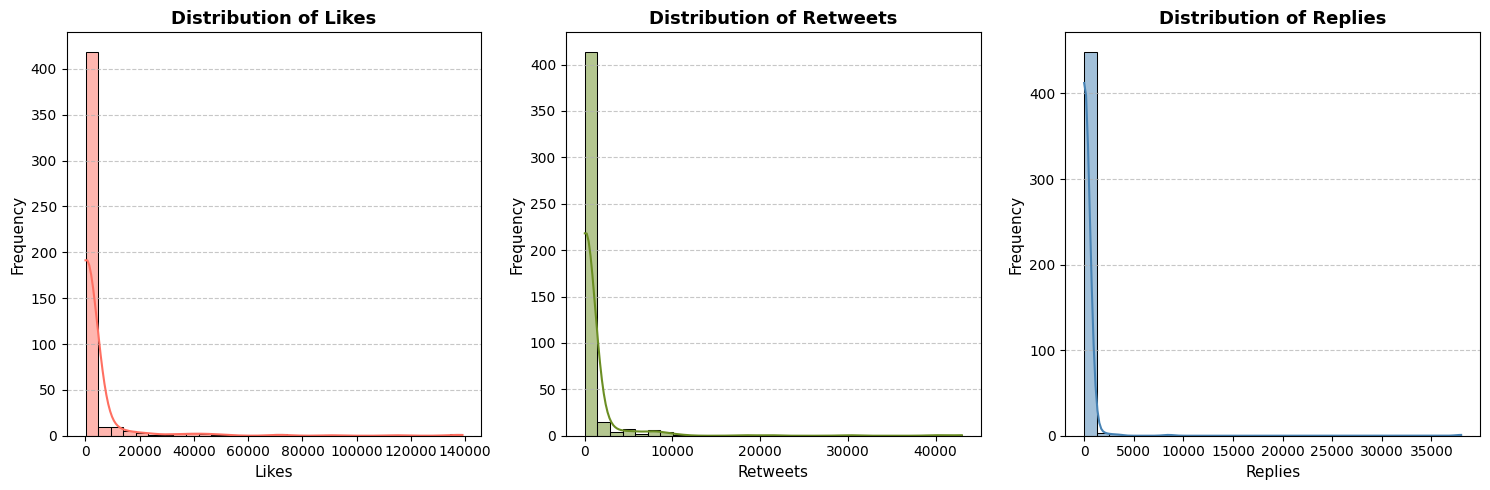

In [44]:
# Define figure size
plt.figure(figsize=(15, 5))

# Common styling
colors = ['#FF6F61', '#6B8E23', '#4682B4'] 
titles = ['Distribution of Likes', 'Distribution of Retweets', 'Distribution of Replies']
columns = ['Likes', 'Retweets', 'Replies']

# Loop through each metric (Likes, Retweets, Replies)
for i, col in enumerate(columns, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], bins=30, kde=True, color=colors[i-1], edgecolor='black')
    plt.title(titles[i-1], fontsize=13, fontweight='bold')
    plt.xlabel(col, fontsize=11)
    plt.ylabel('Frequency', fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

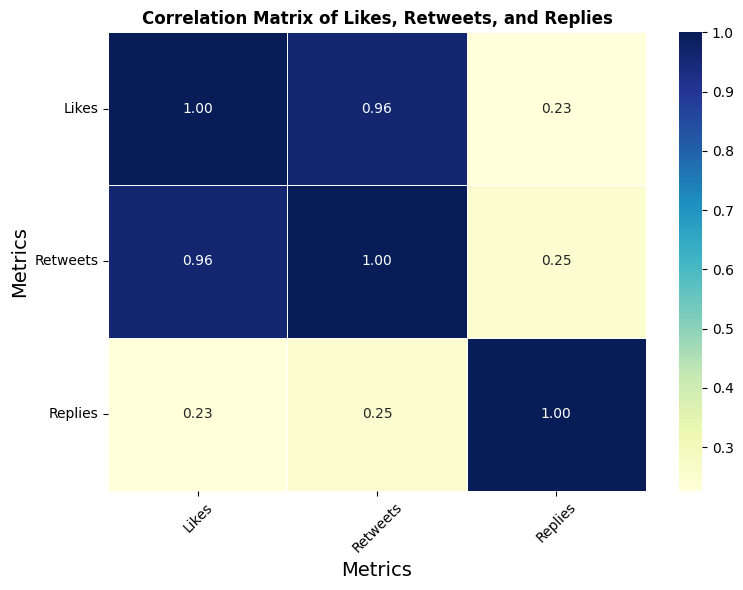

In [47]:
# Calculate the correlation matrix
corr_matrix = df[['Likes', 'Retweets', 'Replies']].corr()

# Plot the heatmap with enhancements
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Likes, Retweets, and Replies', fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Metrics', fontsize=14)
plt.tight_layout()
plt.show()

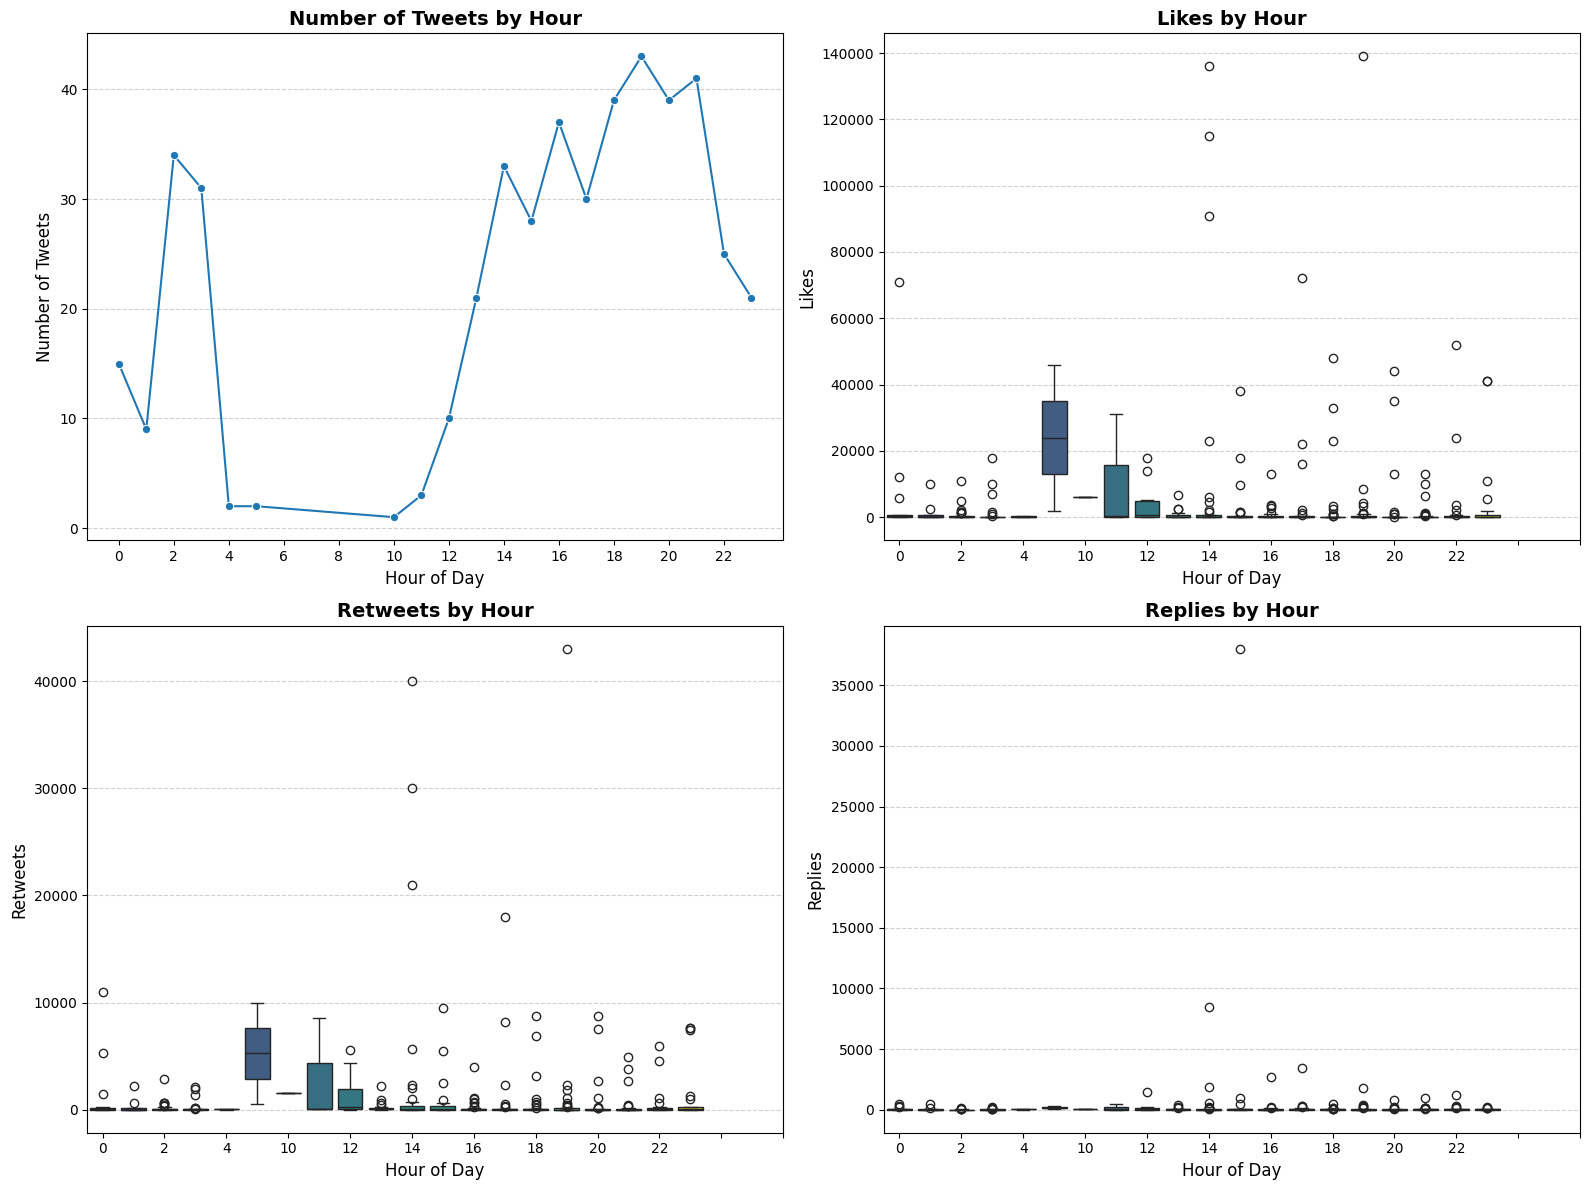

In [49]:
# Extract the hour from the timestamps
df['Hour'] = df['TimeStamps'].dt.hour

# Calculate the number of tweets per hour
tweets_per_hour = df.groupby('Hour').size()

# Set figure size
plt.figure(figsize=(16, 12))

# Define icolor palettes
line_color = "#1f77b4"  # Blue
box_palette = "viridis"  # Aesthetic gradient

# Line Plot: Number of Tweets by Hour
plt.subplot(2, 2, 1)
sns.lineplot(x=tweets_per_hour.index, y=tweets_per_hour.values, marker='o', color=line_color)
plt.title("Number of Tweets by Hour", fontsize=14, fontweight='bold')
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.xticks(range(0, 24, 2))  # Show every 2-hour interval
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Box Plots for Engagement Metrics by Hour
metrics = ["Likes", "Retweets", "Replies"]
titles = ["Likes by Hour", "Retweets by Hour", "Replies by Hour"]

for i, metric in enumerate(metrics, 2):
    plt.subplot(2, 2, i)
    sns.boxplot(x="Hour", y=metric, data=df, palette=box_palette)
    plt.title(titles[i-2], fontsize=14, fontweight='bold')
    plt.xlabel("Hour of Day", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.xticks(range(0, 24, 2))  # Show every 2-hour interval
    plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [50]:
# Split the data
X = df['Cleaned_Tweets']
y = df['Sentiment_Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred_log_reg = log_reg.predict(X_test_tfidf)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_log_reg))
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))


Logistic Regression:
              precision    recall  f1-score   support

    Negative       1.00      0.08      0.14        26
     Neutral       0.00      0.00      0.00        20
    Positive       0.52      1.00      0.68        47

    accuracy                           0.53        93
   macro avg       0.51      0.36      0.27        93
weighted avg       0.54      0.53      0.38        93

Accuracy: 0.5268817204301075


In [51]:
# Encode sentiment labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train the XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')
xgb_model.fit(X_train_tfidf, y_train_encoded)

# Evaluate the model
y_pred_xgb = xgb_model.predict(X_test_tfidf)
print("XGBoost:")
print(classification_report(y_test_encoded, y_pred_xgb, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_xgb))


XGBoost:
              precision    recall  f1-score   support

    Negative       0.69      0.42      0.52        26
     Neutral       0.48      0.70      0.57        20
    Positive       0.60      0.62      0.61        47

    accuracy                           0.58        93
   macro avg       0.59      0.58      0.57        93
weighted avg       0.60      0.58      0.58        93

Accuracy: 0.5806451612903226


In [52]:
# Encode the labels
label_encoder = LabelEncoder()
df['Sentiment_Label'] = label_encoder.fit_transform(df['Sentiment_Label'])
y = df['Sentiment_Label']

# Tokenize the data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_data(texts, labels, max_length=128):
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0), torch.tensor(labels, dtype=torch.long)

# Convert texts to list and labels to NumPy array
X_train_list = X_train.tolist()
X_test_list = X_test.tolist()
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

X_train_ids, X_train_masks, y_train_tensor = encode_data(X_train_list, y_train_encoded)
X_test_ids, X_test_masks, y_test_tensor = encode_data(X_test_list, y_test_encoded)

# Create a custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

train_dataset = CustomDataset(X_train_ids, X_train_masks, y_train_tensor)
test_dataset = CustomDataset(X_test_ids, X_test_masks, y_test_tensor)

# Define the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch'
)

# Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

# Evaluate the model
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
print("BERT:")
print(classification_report(y_test_encoded, preds, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_test_encoded, preds))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.213700,1.129724
2,1.069600,1.009214
3,0.911200,0.986306


BERT:
              precision    recall  f1-score   support

    Negative       0.25      0.04      0.07        26
     Neutral       0.75      0.15      0.25        20
    Positive       0.52      0.94      0.67        47

    accuracy                           0.52        93
   macro avg       0.51      0.37      0.33        93
weighted avg       0.49      0.52      0.41        93

Accuracy: 0.5161290322580645


In [55]:
# Logistic Regression Evaluation
log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg)
log_reg_classification_report = classification_report(y_test, y_pred_log_reg, output_dict=True)

# XGBoost Evaluation
xgb_accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
xgb_classification_report = classification_report(y_test_encoded, y_pred_xgb, output_dict=True, target_names=label_encoder.classes_)

# BERT Evaluation
bert_accuracy = accuracy_score(y_test_encoded, preds)
bert_classification_report = classification_report(y_test_encoded, preds, output_dict=True, target_names=label_encoder.classes_)

# Logs for Training & Validation Loss
logs = [
    {'loss': 1.199700, 'epoch': 1.0},
    {'eval_loss': 1.109024, 'epoch': 1.0},
    {'loss': 1.063300, 'epoch': 2.0},
    {'eval_loss': 0.973764, 'epoch': 2.0},
    {'loss': 0.893600, 'epoch': 3.0},
    {'eval_loss': 0.928286, 'epoch': 3.0}
]

### **Function to Plot Training & Validation Loss**

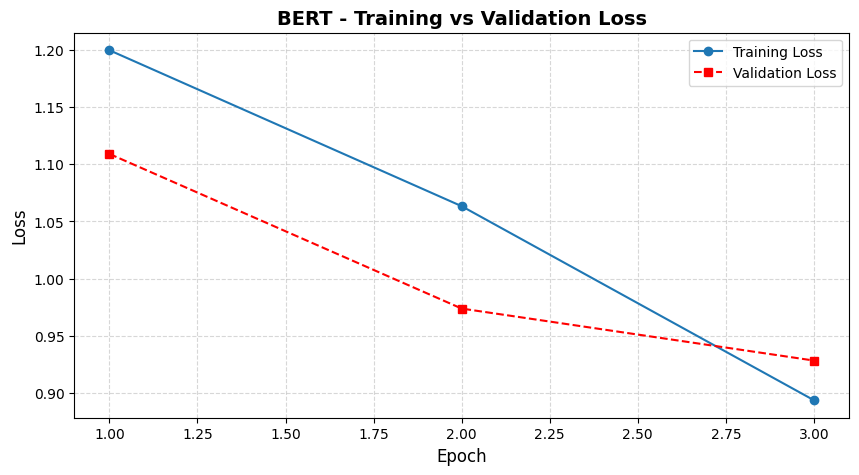

In [59]:
def plot_loss_metrics(logs, model_name):
    train_epochs = [log['epoch'] for log in logs if 'loss' in log and 'eval_loss' not in log]
    train_loss = [log['loss'] for log in logs if 'loss' in log and 'eval_loss' not in log]
    eval_epochs = [log['epoch'] for log in logs if 'eval_loss' in log]
    eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]

    plt.figure(figsize=(10, 5))
    plt.plot(train_epochs, train_loss, label='Training Loss', marker='o', linestyle='-', color='#1f77b4')
    plt.plot(eval_epochs, eval_loss, label='Validation Loss', marker='s', linestyle='--', color='red')

    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title(f'{model_name} - Training vs Validation Loss', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Plot the loss for BERT
plot_loss_metrics(logs, "BERT")


### **Function to Plot Classification Reports**

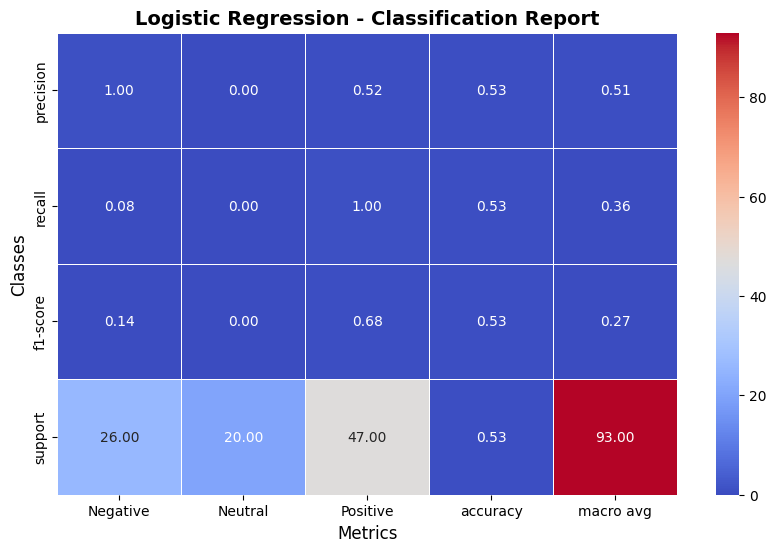

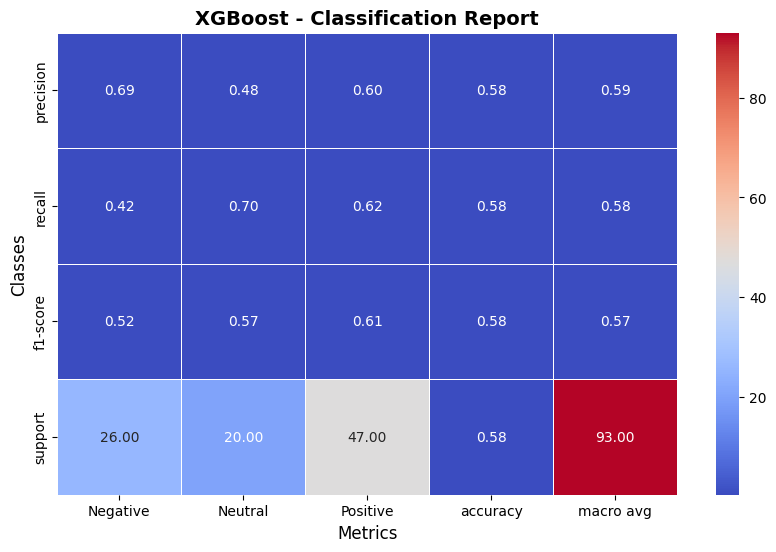

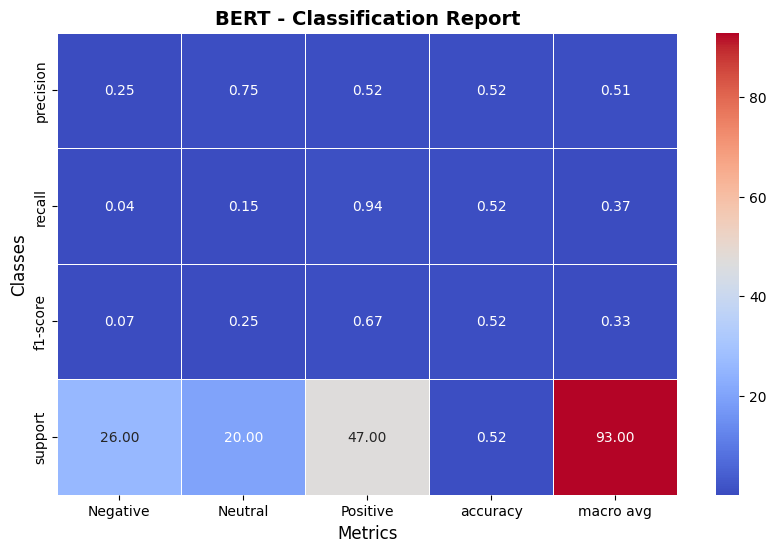

In [58]:
def plot_classification_report(df, model_name):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.iloc[:-1, :].T, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(f'{model_name} - Classification Report', fontsize=14, fontweight='bold')
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Classes', fontsize=12)
    plt.show()

# Convert classification reports to DataFrames
log_reg_df = pd.DataFrame(log_reg_classification_report).transpose()
xgb_df = pd.DataFrame(xgb_classification_report).transpose()
bert_df = pd.DataFrame(bert_classification_report).transpose()

# Plot classification reports
plot_classification_report(log_reg_df, 'Logistic Regression')
plot_classification_report(xgb_df, 'XGBoost')
plot_classification_report(bert_df, 'BERT')

### **Plot Model Accuracy Comparison**

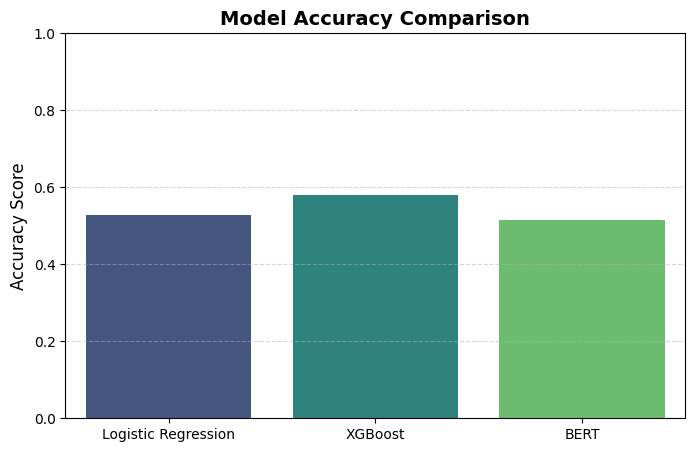

In [60]:
models = ['Logistic Regression', 'XGBoost', 'BERT']
accuracies = [log_reg_accuracy, xgb_accuracy, bert_accuracy]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.ylim(0, 1)
plt.ylabel('Accuracy Score', fontsize=12)
plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

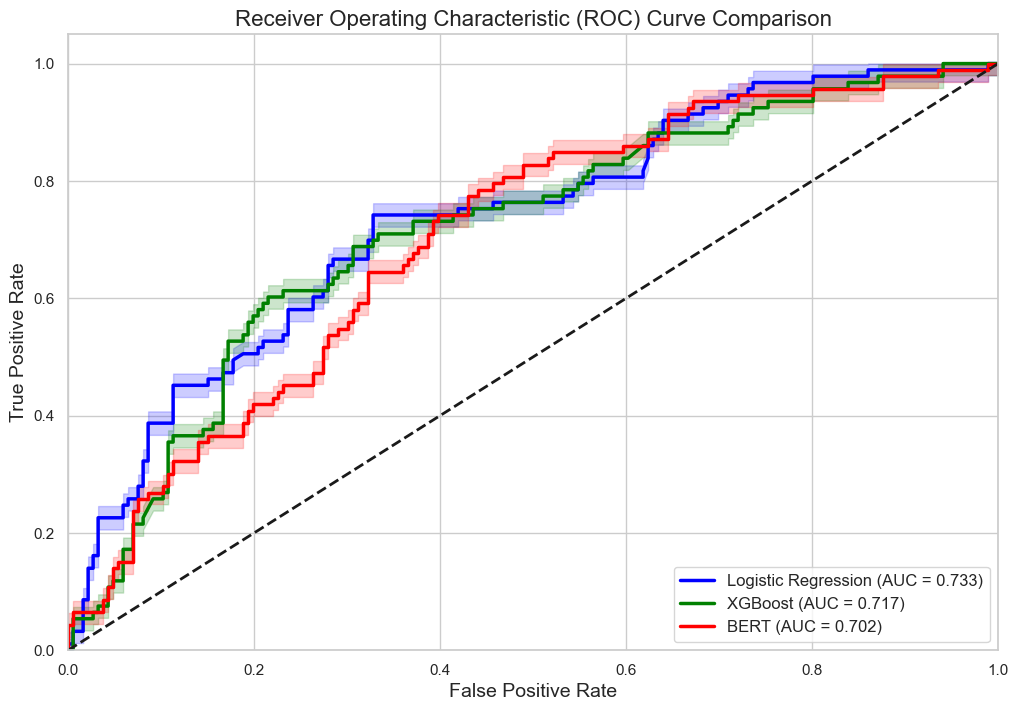

In [63]:
# Binarize the output for multi-class ROC
y_test_binarized = label_binarize(y_test, classes=label_encoder.classes_)
n_classes = y_test_binarized.shape[1]

# Predictions for each model
y_score_log_reg = log_reg.decision_function(X_test_tfidf)
y_score_xgb = xgb_model.predict_proba(X_test_tfidf)
y_score_bert = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()

# Initialize dictionaries
fpr, tpr, roc_auc = {}, {}, {}

models = {
    'Logistic Regression': y_score_log_reg,
    'XGBoost': y_score_xgb,
    'BERT': y_score_bert
}

# Define colors for each model
model_colors = {
    'Logistic Regression': 'blue',
    'XGBoost': 'green',
    'BERT': 'red'
}

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

for model_name, y_score in models.items():
    for i in range(n_classes):
        fpr[model_name, i], tpr[model_name, i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[model_name, i] = auc(fpr[model_name, i], tpr[model_name, i])

    # Compute micro-average ROC curve and area
    fpr[model_name, "micro"], tpr[model_name, "micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
    roc_auc[model_name, "micro"] = auc(fpr[model_name, "micro"], tpr[model_name, "micro"])

    # Plot micro-average ROC curve
    color = model_colors[model_name]
    plt.plot(fpr[model_name, "micro"], tpr[model_name, "micro"], color=color, lw=2.5,
             label=f'{model_name} (AUC = {roc_auc[model_name, "micro"]:.3f})')
    
    # Adding a shaded confidence region (simulated with slight variation)
    plt.fill_between(fpr[model_name, "micro"], np.maximum(tpr[model_name, "micro"] - 0.02, 0),
                     np.minimum(tpr[model_name, "micro"] + 0.02, 1), color=color, alpha=0.2)

# Diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Labels and styling
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()


In [49]:
# Sample input data
data = {
    'TEXT INPUT': [
        "The smartphone's battery life is exceptional and lasts all day.",
        "My new laptop is slow and crashes frequently.",
        "These headphones have average sound quality but are very comfortable.",
        "The smartwatch tracks my fitness activities accurately.",
        "The vacuum cleaner is efficient and works on all surfaces well."
    ],
    'EXPECT RESULT': ["Positive", "Negative", "Neutral", "Positive", "Positive"]
}

# Create DataFrame
df = pd.DataFrame(data)

# Initialize BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Function to get BERT model outputs
def get_bert_output(texts, tokenizer, model):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
    outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1).detach().numpy()
    predicted_labels = np.argmax(probabilities, axis=1)
    return predicted_labels, probabilities

# Get BERT outputs
bert_preds, bert_probs = get_bert_output(df['TEXT INPUT'].tolist(), bert_tokenizer, bert_model)
df['BERT OUT'] = label_encoder.inverse_transform(bert_preds)
df['BERT PROB'] = bert_probs.max(axis=1)

# XGBoost predictions and probabilities
xgb_probs = xgb_model.predict_proba(tfidf.transform(df['TEXT INPUT']))
xgb_preds = np.argmax(xgb_probs, axis=1)
df['XGBOOST OUT'] = label_encoder.inverse_transform(xgb_preds)
df['XGBOOST PROB'] = xgb_probs.max(axis=1)

# Logistic Regression predictions and probabilities
log_reg_probs = log_reg.predict_proba(tfidf.transform(df['TEXT INPUT']))
log_reg_preds = np.argmax(log_reg_probs, axis=1)
df['LOGISTIC OUT'] = label_encoder.inverse_transform(log_reg_preds)
df['LOGISTIC PROB'] = log_reg_probs.max(axis=1)

# Display the DataFrame
print(df)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


                                          TEXT INPUT EXPECT RESULT  BERT OUT  \
0  The smartphone's battery life is exceptional a...      Positive         2   
1      My new laptop is slow and crashes frequently.      Negative         2   
2  These headphones have average sound quality bu...       Neutral         1   
3  The smartwatch tracks my fitness activities ac...      Positive         2   
4  The vacuum cleaner is efficient and works on a...      Positive         2   

   BERT PROB  XGBOOST OUT  XGBOOST PROB  LOGISTIC OUT  LOGISTIC PROB  
0   0.378864            1      0.591316             2       0.656179  
1   0.393317            2      0.725976             2       0.518207  
2   0.373290            1      0.729380             2       0.581468  
3   0.381130            1      0.955020             2       0.486561  
4   0.373292            1      0.873703             2       0.521533  
